Let's start by reading in the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#We assume data is in a parallel directory to this one called 'data'
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/data/'
print(datadir)

/Users/briand/Desktop/ds course/ipython/data/


In [2]:
#Student put in read data command here:
data = pd.read_csv(datadir + 'survey_responses_2018.csv', header = 0, sep=',')

Let's look at the column headers and use something more descriptive

In [3]:
#Student put in code to look at column names
data.columns

Index(['id', 'cs_python', 'cs_java', 'cs_c', 'cs_perl', 'cs_javascript',
       'cs_r', 'cs_sas', 'profile_1', 'profile_2', 'profile_3', 'profile_4',
       'profile_5', 'profile_6', 'profile_7', 'fruit', 'len_answer', 'season',
       'experience_coded', 'experience'],
      dtype='object')

Column names like 'profile_1-profile_7' aren't very descriptive. As a quick data maintenance task, let's rename the columns starting with 'profile'. The dictionary in the next cell maps the integer index to a descriptive text.

Tactically, let's loop through each column name. Within the loop let's check whether the column name starts with 'profile.' If it does, let's create a new name that swaps the key with the value using profile_mapping dictionary (i.e., profile_1 -> profile_Viz). We then add the new column name to a list. If it doesn't start with 'profile' just add the old column name to the list. 

In [4]:
profile_mapping = {1:'Viz',
                   2:'CS',
                   3:'Math',
                   4:'Stats',
                   5:'ML',
                   6:'Bus',
                   7:'Com'}

In [5]:
#Student put code here to change the header names
newcols = []

for colname in data.columns:
    
    if colname[0:7] == 'profile':
        
        newcols.append('profile_{}'.format(profile_mapping[int(colname[-1])]))
        
    else:
        
        newcols.append(colname)
    
#Now swap the old columns with the values in newcols    
data.columns = newcols    

Let's use this data to illustrate common data analytic techniques. We have one numeric variable (len_answer) and different categorical variables which may carry some signal of the 'len_answer' variable. 

'Len_answer' is the character count of the response to the following question: "Besides the examples given in lecture 1, discuss a case where data science has created value for some company. Please explain the company's goals and how any sort of data analysis could have helped the company achieve said goals." As this is a subjective business question, let's hypothesize that students with more professional experience might be more likely to give longer answers. 

In more technical terms, we'll test whether the variance of len_answer can be explained away by the categorical representation of a student's experience. 

The first thing we should do is look at the distribution of len_answer.

(array([30., 68., 34., 14.,  7.,  2.,  1.,  1.,  0.,  1.]),
 array([   0. ,  298.9,  597.8,  896.7, 1195.6, 1494.5, 1793.4, 2092.3,
        2391.2, 2690.1, 2989. ]),
 <a list of 10 Patch objects>)

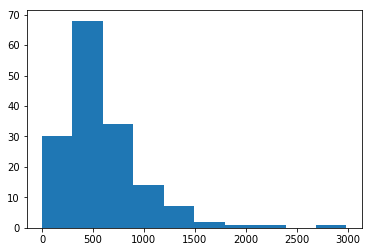

In [6]:
#Student - build and plot a histogram here
plt.hist(data.len_answer)

It looks like we may have at least one strong outlier and somewhat of a log-normal distribution. Let's also use the Pandas describe() method to get a stronger sense of the distribution.

In [7]:
data.len_answer.describe()

count     158.000000
mean      589.708861
std       417.568947
min         0.000000
25%       327.500000
50%       497.500000
75%       726.500000
max      2989.000000
Name: len_answer, dtype: float64

Let's consider cleaning up the data. We'll remove the top k values as well as those with a length less than 50 (which we think is a generous minimum to communicate a reasonable answer.

Create a new data_frame that removes these outliers.

In [19]:
#Write a function to get the kth largest value of an array
def get_kth_largest(inarray, k):
    inarray.sort()
    return inarray[-k]

k = 3
kth_largest = get_kth_largest(np.array(data.len_answer.values), 3)
#Question = why did we wrap the series into an np.array() call in the above function call?

#Student create a filtered data frame here
outlier_filter = (data.len_answer > 50) & (data.len_answer < kth_largest)
data_clean = data[outlier_filter]

#Compare the shape of both dataframes
data_clean.shape, data.shape

((152, 20), (158, 20))

Now that we have cleaned our data, let's run a pairwise t-test on each experience level to see if their difference in len_answer is statistically significant. To run a t-test, we'll need the mean, standard-deviation and count for each group. We can achieve this with a pandas groupby operation.

In [20]:
#Student input code here
data_clean_grouped = data_clean[['len_answer', 'experience']].groupby(['experience']).agg(['mean', 'std', 'count'])
data_clean_grouped

len_answer                  
                                                 mean         std count
experience                                                             
2-5 years, I'm getting good at what I do!  644.852941  316.607599    34
5+ years, I'm a veteran!                   607.785714  427.640248    14
< 2 years, I'm fresh!                      460.941176  195.111303    34
None, I just finished my undergrad!        567.128571  344.456258    70

Visually, we can see a potential split between the [0, 2] year experience range and the [2+] experience range. Let's be more rigorous and run t-tests. Let's write a function that takes in the necessary statistics and returns a p-value.

Remember, the t-stat for the difference between two means is:

<center>$t = \frac{\hat{\mu_1} - \hat{\mu_2}}{\sqrt{\frac{\hat{\sigma_1}^2}{n_1} + \frac{\hat{\sigma_2}^2}{n_2}}}$</center>

The p-value can be found using a t-distribution, but for simplicity, let's approximate this with the normal distribution. For the 2-tailed test, the p-value is: 2 * (1 - Norm.CDF(T)).

In [21]:
#Student complete the function
from scipy.stats import norm

def pvalue_diffmeans_twotail(mu1, sig1, n1, mu2, sig2, n2):
    '''
    P-value calculator for the hypothesis test of mu1 != mu2.
    Takes in the approprate inputs to compute the t-statistic for the difference between means
    Outputs a p-value for a two-sample t-test.
    '''
    diff = mu1 - mu2
    stderror = np.sqrt(sig1**2 / n1 + sig2**2 / n2)
    t = diff / stderror
    
    p_value = 2 * (1- norm.cdf(np.abs(t)))
    
    return (t, p_value)

Now loop through all possible pairs in data_clean_grouped and perform a t-test.

In [34]:
#Student put in code here:

#get distinct values in the data frame for the experience variable

#data_grouped = data[['len_answer', 'experience']].groupby(['experience']).agg(['mean', 'std', 'count'])
#ttest_data = data_grouped


ttest_data = data_clean_grouped


grps = ttest_data.index.values

#Now loop through each pair
for i, grp1 in enumerate(grps):
    for grp2 in grps[i + 1:]:
    
        '''
        hint: since the grp name is the index, pull out the record corresponding to that index value. 
        Also, the result of groupby uses a multi-index. So be sure to index on 'len_answer' as well.
        Then pull out the mean, std, and cnt from that result.   
        '''        
        row1 = ttest_data.loc[grp1].loc['len_answer']
        row2 = ttest_data.loc[grp2].loc['len_answer']
    
        tstat, p_value = pvalue_diffmeans_twotail(row1['mean'], row1['std'], row1['count'], row2['mean'], row2['std'], row2['count'])
    
        print('Two tailed T-Test between groups: {} and {}'.format(grp1, grp2))
        print('Diff = {} characters'.format(round(row1['mean'] - row2['mean'], 0)))
        print('The t-stat is {} and p-value is {}'.format(round(tstat, 3), round(p_value, 3)))
        print('')

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and 5+ years, I'm a veteran!
Diff = 37.0 characters
The t-stat is 0.293 and p-value is 0.77

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and < 2 years, I'm fresh!
Diff = 184.0 characters
The t-stat is 2.884 and p-value is 0.004

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and None, I just finished my undergrad!
Diff = 78.0 characters
The t-stat is 1.141 and p-value is 0.254

Two tailed T-Test between groups: 5+ years, I'm a veteran! and < 2 years, I'm fresh!
Diff = 147.0 characters
The t-stat is 1.233 and p-value is 0.218

Two tailed T-Test between groups: 5+ years, I'm a veteran! and None, I just finished my undergrad!
Diff = 41.0 characters
The t-stat is 0.335 and p-value is 0.738

Two tailed T-Test between groups: < 2 years, I'm fresh! and None, I just finished my undergrad!
Diff = -106.0 characters
The t-stat is -2.002 and p-value is 0.045



What are some observations you might have about the above results? Are there any with large deviances that are not statistically significant at at least a 95% level? Is there any issue with using 95% as our threshold for statistical significance? In fact there is. We are running multiple hypothesis tests at once, and doing this is known to increase the probability that we have at least one false positive (i.e., $P(False Positive) = 1 - .95^{Ntests}$). We can apply a simplye but conservative method called the <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">Bonferoni Correction</a>, which says that if we normally would care about an alpha level of $\alpha$ for significance testing, and we're doing $N$ tests, then our new significance level should be $\alpha/N$. This correction is conservative because it assumes that each test is independent. Since each group is repeatedly sampled across pairs, we know that our individual tests are not indeed independent. Nonetheless, we'll see how the results hold under this new regime. 

Also, how do the numbers change if you rerun it using the original data, and not the cleaned data. What is the effect of outliers on the results?

In [35]:
#Rerun everything without cleaning outliers
data_grouped = data[['len_answer', 'experience']].groupby(['experience']).agg(['mean', 'std', 'count'])
ttest_data = data_grouped


grps = ttest_data.index.values

#Now loop through each pair
for i, grp1 in enumerate(grps):
    for grp2 in grps[i + 1:]:
    
        '''
        hint: since the grp name is the index, pull out the record corresponding to that index value. 
        Also, the result of groupby uses a multi-index. So be sure to index on 'len_answer' as well.
        Then pull out the mean, std, and cnt from that result.   
        '''        
        row1 = ttest_data.loc[grp1].loc['len_answer']
        row2 = ttest_data.loc[grp2].loc['len_answer']
    
        tstat, p_value = pvalue_diffmeans_twotail(row1['mean'], row1['std'], row1['count'], row2['mean'], row2['std'], row2['count'])
    
        print('Two tailed T-Test between groups: {} and {}'.format(grp1, grp2))
        print('Diff = {} characters'.format(round(row1['mean'] - row2['mean'], 0)))
        print('The t-stat is {} and p-value is {}'.format(round(tstat, 3), round(p_value, 3)))
        print('')

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and 5+ years, I'm a veteran!
Diff = 76.0 characters
The t-stat is 0.579 and p-value is 0.562

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and < 2 years, I'm fresh!
Diff = 235.0 characters
The t-stat is 3.163 and p-value is 0.002

Two tailed T-Test between groups: 2-5 years, I'm getting good at what I do! and None, I just finished my undergrad!
Diff = 76.0 characters
The t-stat is 0.876 and p-value is 0.381

Two tailed T-Test between groups: 5+ years, I'm a veteran! and < 2 years, I'm fresh!
Diff = 159.0 characters
The t-stat is 1.328 and p-value is 0.184

Two tailed T-Test between groups: 5+ years, I'm a veteran! and None, I just finished my undergrad!
Diff = -0.0 characters
The t-stat is -0.002 and p-value is 0.998

Two tailed T-Test between groups: < 2 years, I'm fresh! and None, I just finished my undergrad!
Diff = -159.0 characters
The t-stat is -2.392 and p-value is 0.017

